In [ ]:
pip install transformers plotly==5.8.0 pyyaml==5.4.1 datasets pytorch-lightning > /dev/null 2>&1

In [ ]:
import pandas as pd
from pprint import pprint
import functools

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl
from transformers import AutoModelForSequenceClassification, CamembertForMaskedLM, AutoTokenizer, AutoConfig
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm.notebook import tqdm

In [ ]:
data = pd.read_csv("/content/train.csv")

In [ ]:
pd.set_option("max_colwidth", None)

In [ ]:
data.sample(7)

,IdCustomer,Text,Target
1549,2117,Fiabilité nulle,Negative
1817,3992,Magnifique,Positive
2929,25,Bon produit,Neutre
2152,582,Très bon odeurs,Positive
3360,1759,Merci beaucoup j'ai bien reçue ma commande et satisfaite,Positive
2536,2933,Cette lampe tourne ma chambre a un club,Positive
2135,3052,Faire attention lors du montage,Positive


In [ ]:
# encoding the target variable

target_map = {"Neutre": 0, "Negative": 1, "Positive": 2}
data["Target"] = data["Target"].map(target_map)

In [ ]:
# dropping the IdCustomer variable

data = data.drop(columns=["IdCustomer"])

In [ ]:
num_labels = 3

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('camembert-base')


In [ ]:
# adding str_target:
str_target_map = {0: "Neutre", 1: "Negative", 2: "Positive"}
data["str_Target"] = data["Target"].map(str_target_map)

In [ ]:
from datasets import Dataset
# creating datasets based on this dataframes
dataset = Dataset.from_pandas(data)

In [ ]:
data.Target.value_counts()

2    2477
1     501
0     389
Name: Target, dtype: int64

In [ ]:
# Stratified Train/Test-split Neutre lable is a minority so wee make sure it appears in both sets.
from sklearn.model_selection import train_test_split 
train_df, validate_df = train_test_split(data, test_size=0.3, stratify= data['Target'])

In [ ]:
train_df.Target.value_counts()

2    1733
1     351
0     272
Name: Target, dtype: int64

In [ ]:
validate_df.Target.value_counts()

2    744
1    150
0    117
Name: Target, dtype: int64

In [ ]:
train_dataset= Dataset.from_pandas(train_df)
val_dataset= Dataset.from_pandas(validate_df)

In [ ]:
def tokenize_batch(samples, tokenizer):
    text = [sample["Text"] for sample in samples]
    labels = torch.tensor([sample["Target"] for sample in samples])
    str_labels = [sample["str_Target"] for sample in samples]
    # The tokenizer handles
    # - Tokenization (amazing right?)
    # - Padding (adding empty tokens so that each example has the same length)
    # - Truncation (cutting samples that are too long)
    # - Special tokens (in CamemBERT, each sentence ends with a special token </s>)
    # - Attention mask (a binary vector which tells the model which tokens to look at. For instance it will not compute anything if the token is a padding token)
    tokens = tokenizer(text, padding="longest", return_tensors="pt")

    return {"input_ids": tokens.input_ids, "attention_mask": tokens.attention_mask, "labels": labels, "str_labels": str_labels, "sentences": text}

In [ ]:
# Représenter la phrase en réalisant la moyenne des embeddings de tous les tokens de la séquence
def average_embeddings(embeddings, attention_mask):
    return (attention_mask[..., None] * embeddings).mean(1)

In [ ]:
num_labels = 3

In [ ]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=16, 
    shuffle=True, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)
val_dataloader = DataLoader(
    val_dataset, 
    batch_size=16, 
    shuffle=False, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
class LightningModel(pl.LightningModule):
    def __init__(self, model_name, num_labels, lr, weight_decay, from_scratch=False):
        super().__init__()
        self.save_hyperparameters()
        if from_scratch:
            # Si `from_scratch` est vrai, on charge uniquement la config (nombre de couches, hidden size, etc.) et pas les poids du modèle 
            config = AutoConfig.from_pretrained(
                model_name, num_labels=num_labels
            )
            self.model = AutoModelForSequenceClassification.from_config(config)
        else:
            # Cette méthode permet de télécharger le bon modèle pré-entraîné directement depuis le Hub de HuggingFace sur lequel sont stockés de nombreux modèles
            self.model = AutoModelForSequenceClassification.from_pretrained(
                model_name, num_labels=num_labels
            )
        self.lr = lr
        self.weight_decay = weight_decay
        self.num_labels = self.model.num_labels

    def forward(self, batch):
        return self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

    def training_step(self, batch):
        out = self.forward(batch)

        logits = out.logits
        # -------- MASKED --------
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(logits.view(-1, self.num_labels), batch["labels"].view(-1))

        # ------ END MASKED ------

        self.log("train/loss", loss)

        return loss

    def validation_step(self, batch, batch_index):
        labels = batch["labels"]
        out = self.forward(batch)

        preds = torch.max(out.logits, -1).indices
        # -------- MASKED --------
        acc = (batch["labels"] == preds).float().mean()
        # ------ END MASKED ------
        self.log("valid/acc", acc)

        f1 = f1_score(batch["labels"].cpu().tolist(), preds.cpu().tolist(), average="macro")
        self.log("valid/f1", f1)

    def predict_step(self, batch, batch_idx):
        """La fonction predict step facilite la prédiction de données. Elle est 
        similaire à `validation_step`, sans le calcul des métriques.
        """
        out = self.forward(batch)

        return torch.max(out.logits, -1).indices

    def configure_optimizers(self):
        return torch.optim.AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )

In [ ]:
lightning_model = LightningModel("camembert-base", num_labels, lr=3e-5, weight_decay=0.)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.bias

In [ ]:
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor="valid/acc", mode="max")

camembert_trainer = pl.Trainer(
    max_epochs=20,
    gpus=1,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="valid/acc", patience=4, mode="max"),
        model_checkpoint,
    ]
)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
camembert_trainer.fit(lightning_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                               | Params
-------------------------------------------------------------
0 | model | CamembertForSequenceClassification | 110 M 
-------------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
442.497   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/data.py:84: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/data.py:84: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
lightning_model = LightningModel.load_from_checkpoint(checkpoint_path=model_checkpoint.best_model_path)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.bias

In [ ]:
ID_TO_LABEL= [0, 1, 2]

In [ ]:
def get_preds(model, tokenizer, sentence):
    tokenized_sentence = tokenizer(sentence, return_tensors="pt")
    input_ids, attention_mask = tokenized_sentence.input_ids, tokenized_sentence.attention_mask

    out = model(
        input_ids=tokenized_sentence.input_ids,
        attention_mask=tokenized_sentence.attention_mask
    )

    logits = out.logits

    probas = torch.softmax(logits, -1).squeeze()

    pred = torch.argmax(probas)

    return ID_TO_LABEL[pred], probas[pred].item()

In [ ]:
camembert_preds = camembert_trainer.predict(lightning_model, dataloaders=val_dataloader)
camembert_preds = torch.cat(camembert_preds, -1)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 148it [00:00, ?it/s]

In [ ]:
label_names = [0, 1, 2]
labels = val_dataset['Target']

In [ ]:
def plot_confusion_matrix(labels, preds, label_names):
    confusion_norm = confusion_matrix(labels, preds.tolist(), labels=list(range(len(label_names))), normalize="true")
    confusion = confusion_matrix(labels, preds.tolist(), labels=list(range(len(label_names))))
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(
        confusion_norm,
        annot=confusion,
        cbar=False,
        fmt="d",
        xticklabels=label_names,
        yticklabels=label_names,
        cmap="viridis"
    )

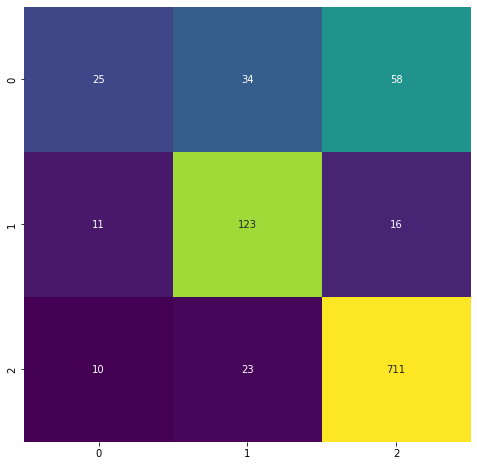

In [ ]:
plot_confusion_matrix(labels, camembert_preds, label_names)

## Test set prediction


In [ ]:
testset = pd.read_csv("/content/test.csv")

In [ ]:
testset.head()

,IdCustomer,Text
0,3385,"pas vraiment puissante,\r\nfaisceau large"
1,605,L'odeur ne dure pas sur les vêtements et très très concentré
2,3983,Peut-être
3,2460,Pratique
4,4294,Pratique


In [ ]:
IdCustomer_list = testset["IdCustomer"].to_list()
Text_list = testset["Text"].to_list()

In [ ]:
predictions =[]

for elm in Text_list:
  label_predicted, proba = get_preds(lightning_model.model, tokenizer, elm)
  predictions.append(label_predicted)

In [ ]:
len(predictions)

1123

In [ ]:
testset["Target"]=predictions

In [ ]:
testset.head(10)

,IdCustomer,Text,Target
0,3385,"pas vraiment puissante,\r\nfaisceau large",1
1,605,L'odeur ne dure pas sur les vêtements et très très concentré,1
2,3983,Peut-être,2
3,2460,Pratique,2
4,4294,Pratique,2
5,4159,La qualité et nulle,1
6,1421,Bon Travail et Bonne continuation,2
7,299,Je suis satisfait de tout agent jumua merci,2
8,3584,Satisfaite :),2
9,3465,Bon rapport qualité prix,2


In [ ]:
submission = testset[["IdCustomer","Target"]]

In [ ]:
submission.sample(5)

,IdCustomer,Target
337,3691,2
169,961,2
484,3607,2
814,3880,2
389,3654,2


In [ ]:
mapping = {0: "Neutre" , 1: "Negative", 2: "Positive"}

In [ ]:
submission["Target"] = submission["Target"].map(mapping)

<ipython-input-44-e39aacf16576>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission["Target"] = submission["Target"].map(mapping)


In [ ]:
submission["Target"].value_counts()

Positive    879
Negative    175
Neutre       69
Name: Target, dtype: int64

In [ ]:
submission.to_csv('submisson_3.csv', index=False)

## comparing Cmareka model preds vs camembert preds

In [ ]:
cm_preds = pd.read_csv("/content/submission(cmareka).csv")

In [ ]:
camembert_preds = submission

In [ ]:
testset.head(10)

,IdCustomer,Text,Target
0,3385,"pas vraiment puissante,\r\nfaisceau large",1
1,605,L'odeur ne dure pas sur les vêtements et très très concentré,1
2,3983,Peut-être,2
3,2460,Pratique,2
4,4294,Pratique,2
5,4159,La qualité et nulle,1
6,1421,Bon Travail et Bonne continuation,2
7,299,Je suis satisfait de tout agent jumua merci,2
8,3584,Satisfaite :),2
9,3465,Bon rapport qualité prix,2


In [ ]:
cm_preds.head(10)

,IdCustomer,Target
0,3385,Neutre
1,605,Negative
2,3983,Neutre
3,2460,Positive
4,4294,Positive
5,4159,Negative
6,1421,Positive
7,299,Positive
8,3584,Positive
9,3465,Positive


In [ ]:
camembert_preds.head(10)

,IdCustomer,Target
0,3385,Negative
1,605,Negative
2,3983,Positive
3,2460,Positive
4,4294,Positive
5,4159,Negative
6,1421,Positive
7,299,Positive
8,3584,Positive
9,3465,Positive


In [ ]:
camembert_preds_list = camembert_preds.Target.to_list()

In [ ]:
cm_preds_list = cm_preds.Target.to_list()

In [ ]:
camembert_preds_list

In [ ]:
cm_preds_list

In [ ]:
# calculating the intersection between the preds
# total number of preds = 1123
total = 1123
inter = 0
for i in range(len(camembert_preds_list)):
  if (camembert_preds_list[i] == cm_preds_list[i]):
    inter = inter + 1

In [ ]:
inter

980

In [ ]:
intersection_score = inter/total
print(intersection_score)

0.8726625111308994


In [ ]:
diff_testset = testset

In [ ]:
#extracting the different preds and verify manually

diff_testset['Target_cmareka'] = cm_preds_list
diff_testset['Target_camembert'] = camembert_preds_list

In [ ]:
diff_testset

,IdCustomer,Text,Target,Target_cmareka,Target_camembert
0,3385,"pas vraiment puissante,\r\nfaisceau large",1,Neutre,Negative
1,605,L'odeur ne dure pas sur les vêtements et très très concentré,1,Negative,Negative
2,3983,Peut-être,2,Neutre,Positive
3,2460,Pratique,2,Positive,Positive
4,4294,Pratique,2,Positive,Positive
...,...,...,...,...,...
1118,1913,c'est parfait,2,Positive,Positive
1119,3139,Faut pas trop charger sur les côtés,0,Neutre,Neutre
1120,2002,Attention au bonnet de la housse de matelas,1,Positive,Negative
1121,2059,Très confortable et bien chaud ^^ merci :),2,Positive,Positive


In [ ]:
diff_testset = diff_testset.drop(['Target'], axis=1)

In [ ]:
# Getting the index of differnt 

inter = 0
indice_list=[]
for i in range(total):
  if (camembert_preds_list[i] == cm_preds_list[i]):
    inter = inter + 1
  else:
    indice_list.append(i)

In [ ]:
len(indice_list)

143

In [ ]:
# creating a dataframe of those preds

diff_preds = diff_testset.iloc[indice_list]

In [ ]:
diff_preds.sample(10)

,IdCustomer,Text,Target_cmareka,Target_camembert
754,699,"L'odeur est une odeur de lessive comme les autres, forte à mon goût. Pas une odeur de fleurs blanches comme indiquée.",Negative,Neutre
167,1955,Sympathique,Neutre,Positive
404,265,pas mal,Neutre,Positive
345,1657,Odeur trop légère,Negative,Neutre
684,3665,Tellement sghyr c'est presque Impossible d'utiliser la brosse,Negative,Positive
806,2688,a ete endomage facilement,Positive,Negative
1102,2194,"Bonjour,\r\nj'ai passé une commande sur 2 poufs lors du black friday le 6 novembre. J'ai reçu un sms de confirmation mardi le 10/11 m'indiquant que le livreur va me contacter.\r\nCe livreur ne m'a jamais appelé, de mon côté je l'ai appelé plusieurs fois mais soit il ne répond pas, soit il me dit qu'il va venir sans me recontacter une autre fois.\r\nJ'ai aussi passé une réclamation mais sans résultats.\r\nEnfin, Mardi le 17/11, ma commande est passée à l'état livrée, et je n'ai pas encore reçu mon colis.",Negative,Positive
298,1007,C est comme tous Les bavettes,Positive,Negative
414,2120,N’éclaire pas l’obscurité mais se déclenche dès qu’on s’en approche et peut effrayer les intrus,Neutre,Positive
76,828,Moyen pas mal par rapport son prix,Neutre,Positive
